In [1]:
import torch as torch
import torch.nn as nn
from typing import Optional
from math import floor, log2, sqrt
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6.6

In [2]:
INIT_STRAT = 'hyperspherical-shell'


class FFF(nn.Module):
    def __init__(self, nIn: int, nOut: int, depth: Optional[int] = None):
        super().__init__()
        self.depth = depth or int(floor(log2(nIn)))  # depth is the number of decision boundaries
        nNodes = 2 ** self.depth - 1

        self.lambdas = []

        # each node "holds" a basis-vector in INPUT space (.X) and in OUTPUT space (.Y)

        if INIT_STRAT == 'gaussian':
            # This from orig authors; scaling looks off for self.Y
            def create_basis_vectors_of(length, scaling):
                return nn.Parameter(torch.empty(nNodes, length).uniform_(-scaling, scaling))
            self.X = create_basis_vectors_of(length=nIn, scaling=1/sqrt(nIn))
            self.Y = create_basis_vectors_of(length=nOut, scaling=1/sqrt(self.depth + 1))

        elif INIT_STRAT == 'hyperspherical-shell':
            # Initialize vectors on INPUT/OUTPUT space unit hypersphere
            #   (idea: basis vectors should be of unit length).
            def create_random_unit_vectors_of(length):
                weights = torch.randn(nNodes, length)  # Initialize weights randomly
                weights = F.normalize(weights, p=2, dim=-1)  # L2-Normalize along the last dimension
                return nn.Parameter(weights)
            self.X = create_random_unit_vectors_of(length=nIn)
            self.Y = create_random_unit_vectors_of(length=nOut)

    def clear_lambdas(self):
        self.lambdas = []

    def get_lambdas(self):
        return self.lambdas

    def forward(self, x: torch.Tensor, train_key=False, save_lambda=False):
        nBatch, nIn, nOut = x.shape[0], self.X.shape[-1], self.Y.shape[-1]

        current_node = torch.zeros(nBatch, dtype=torch.long, device=x.device)

        # Walk the tree, assembling y piecemeal
        y = torch.zeros((nBatch, nOut), dtype=torch.float, device=x.device)
        for depth in range(self.depth):
            # Project x onto the current node's INPUT basis vector
            #   λ = x DOT currNode.X
            # (nBatch, nIn,) (nBatch, nIn) -> (nBatch,)
            λ = torch.einsum("b i, b i -> b", x, self.X[current_node])

            if save_lambda:
                self.lambdas.append(λ.detach().cpu().numpy())

            y += torch.einsum("b, b j -> b j", λ, self.Y[current_node])

            branch_choice = (λ > 0.0).long()
            current_node = (current_node * 2) + 1 + branch_choice
        return y


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net_FFF(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = FFF(16 * 5 * 5, 120)
        self.fc2 = FFF(120, 84)
        self.fc3 = FFF(84, 10)

    def forward(self, x, train_key=False, save_lambda=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x, train_key=train_key, save_lambda=save_lambda))
        x = F.relu(self.fc2(x, train_key=train_key, save_lambda=save_lambda))
        x = self.fc3(x, train_key=train_key, save_lambda=save_lambda)
        return x

In [8]:

def evaluate(net: nn.Module, data_loader: torch.utils.data.DataLoader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    return 100 * correct / total

def train(net: nn.Module,
          trainloader: torch.utils.data.DataLoader,
          testloader: torch.utils.data.DataLoader,
          epochs: int):

    optimizer = optim.AdamW(net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs, train_key=True, save_lambda= i == 0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch} loss: {running_loss / len(trainloader)}")
        #print(f"Train accuracy: {evaluate(net, trainloader)}")
        #print(f"Test accuracy: {evaluate(net, testloader)}")

In [9]:
net_FFF = Net_FFF().to(device)

In [10]:
train(net_FFF, trainloader, testloader, 40)

Epoch 0 loss: 2.043364513560634
Epoch 1 loss: 1.6790310845655554
Epoch 2 loss: 1.5462190641466613
Epoch 3 loss: 1.462739994153952
Epoch 4 loss: 1.3950032196996156
Epoch 5 loss: 1.3468775615057982
Epoch 6 loss: 1.3022847788413163
Epoch 7 loss: 1.261910514148605
Epoch 8 loss: 1.218841100440306
Epoch 9 loss: 1.1861360589866443
Epoch 10 loss: 1.158116952385134
Epoch 11 loss: 1.1291243792189967
Epoch 12 loss: 1.106317627917775
Epoch 13 loss: 1.0839008922162263
Epoch 14 loss: 1.0583625958703669
Epoch 15 loss: 1.0381419019930809
Epoch 16 loss: 1.016593619228324
Epoch 17 loss: 1.001713150450031
Epoch 18 loss: 0.9889386282552539
Epoch 19 loss: 0.9746950509603066
Epoch 20 loss: 0.960614658225223
Epoch 21 loss: 0.9458226791733061
Epoch 22 loss: 0.9370245779566753
Epoch 23 loss: 0.92335737894868
Epoch 24 loss: 0.9136080654990643
Epoch 25 loss: 0.9042253799145789
Epoch 26 loss: 0.8911917846830909
Epoch 27 loss: 0.8822698213560197
Epoch 28 loss: 0.8748705842915703
Epoch 29 loss: 0.8762345170730825
E

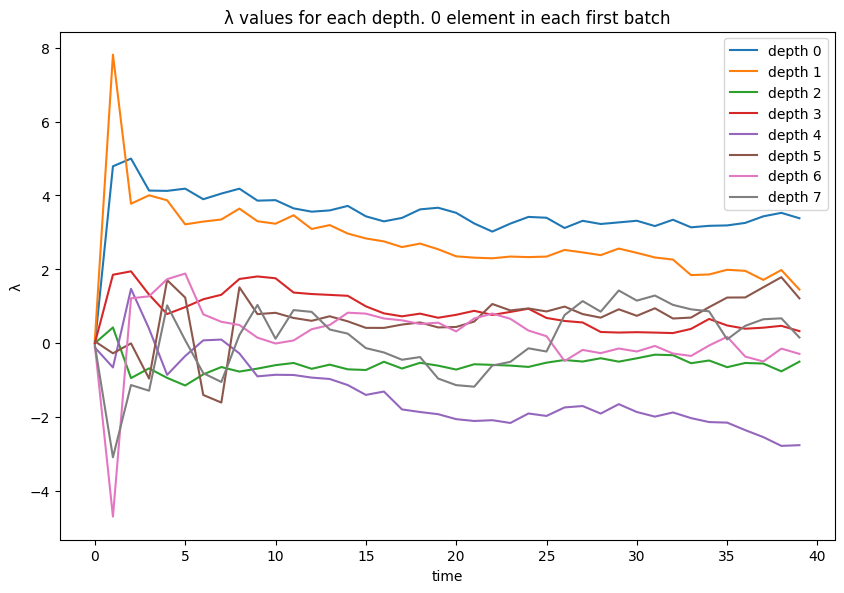

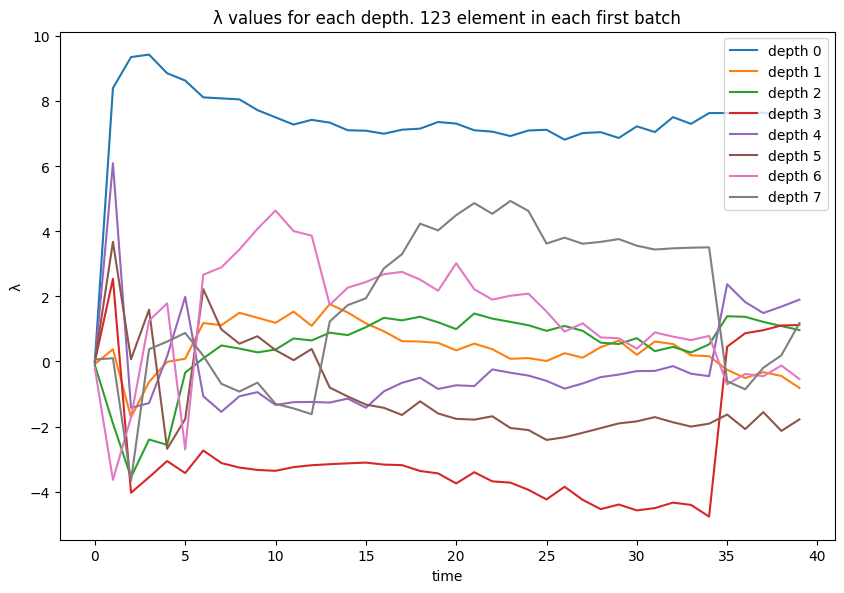

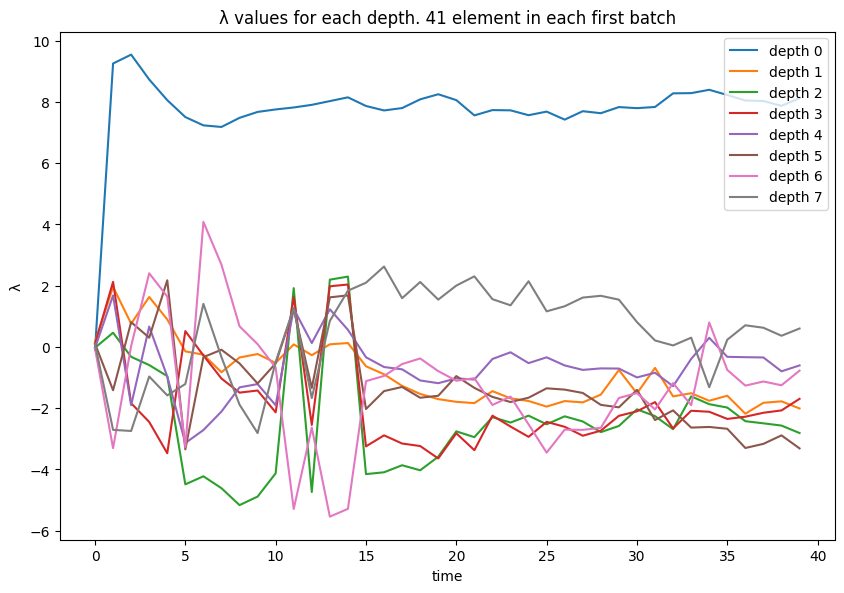

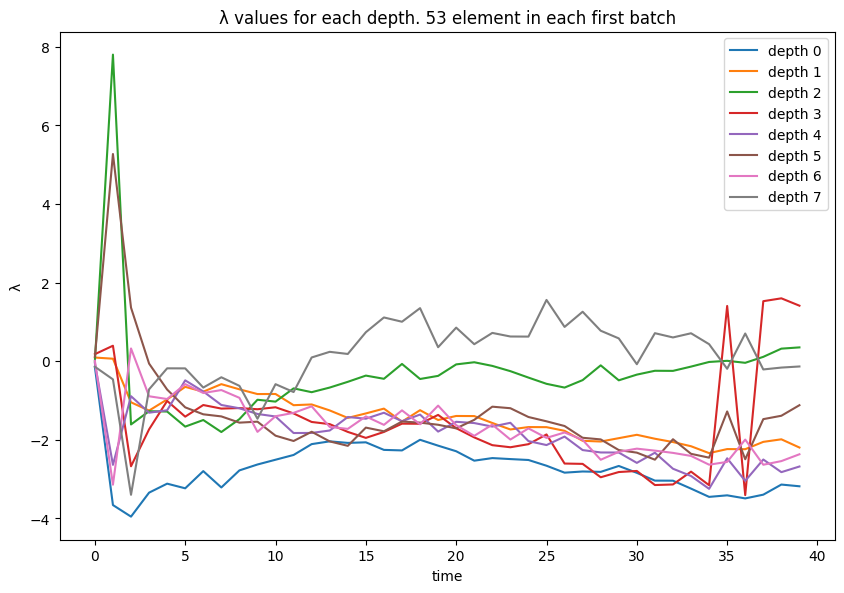

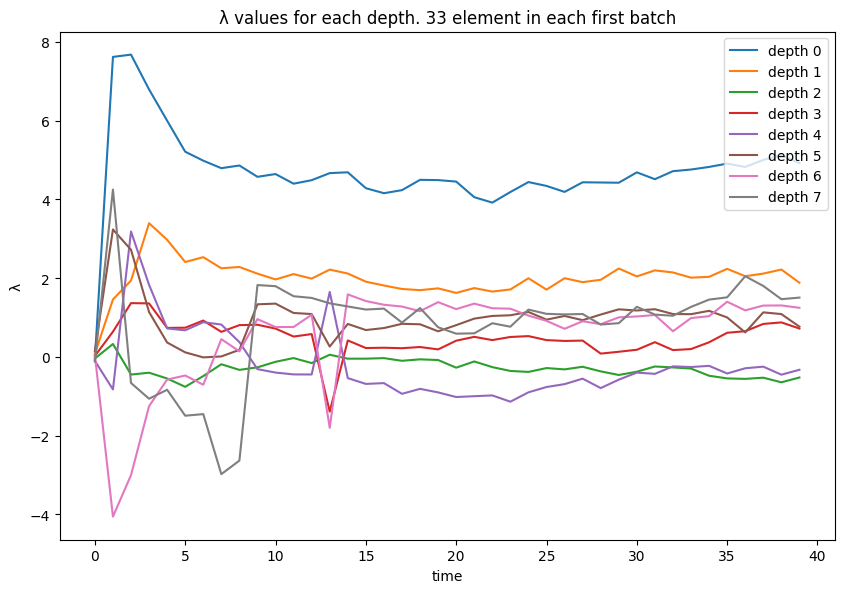

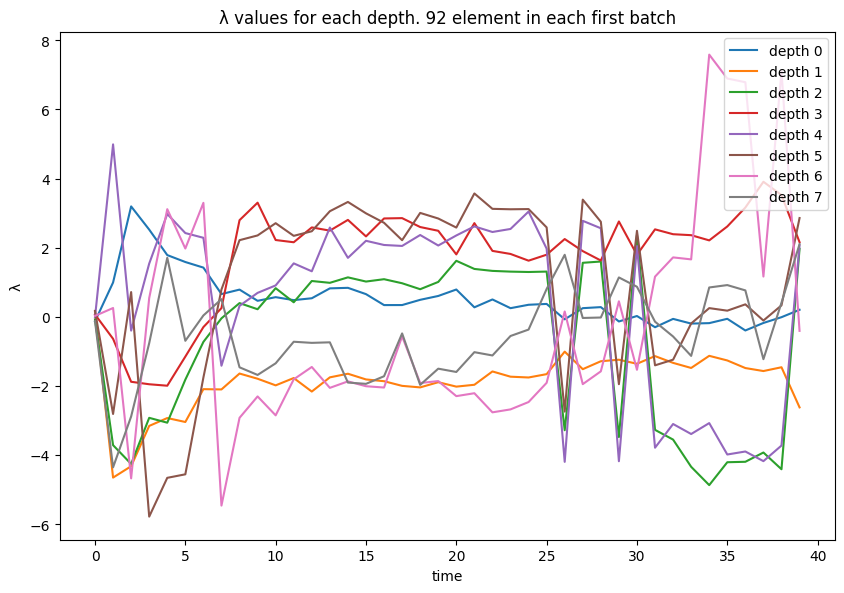

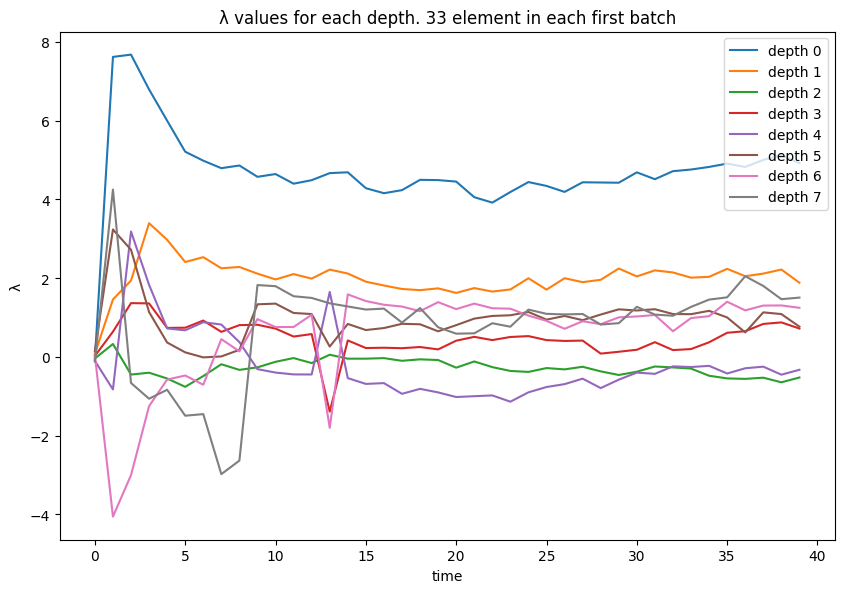

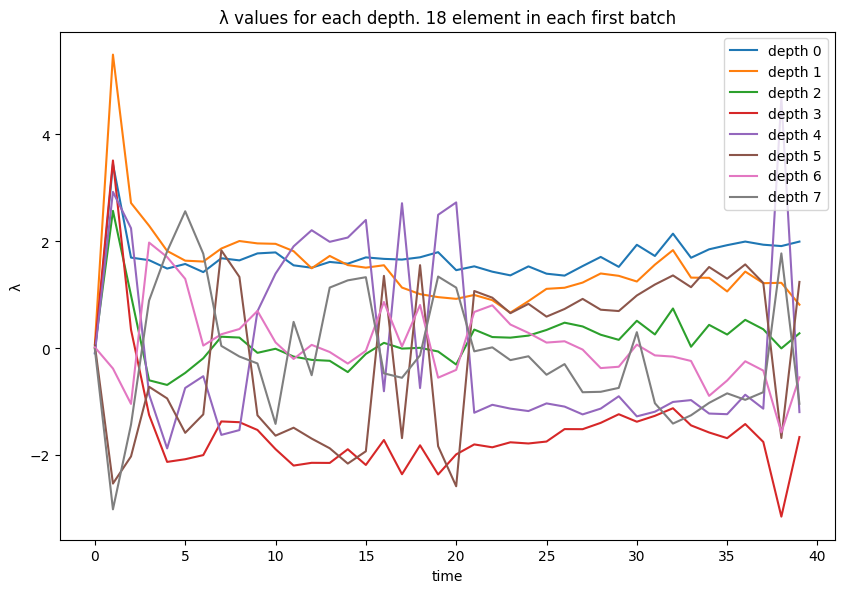

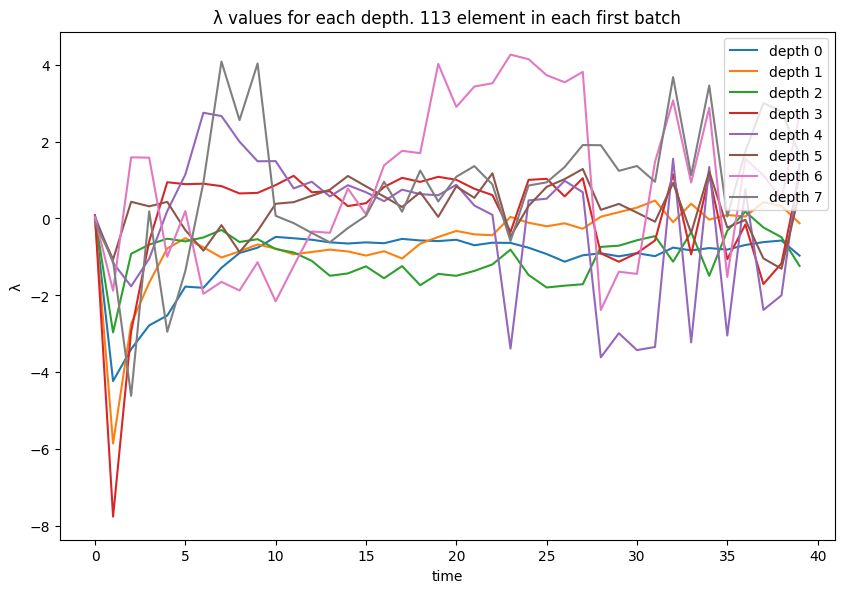

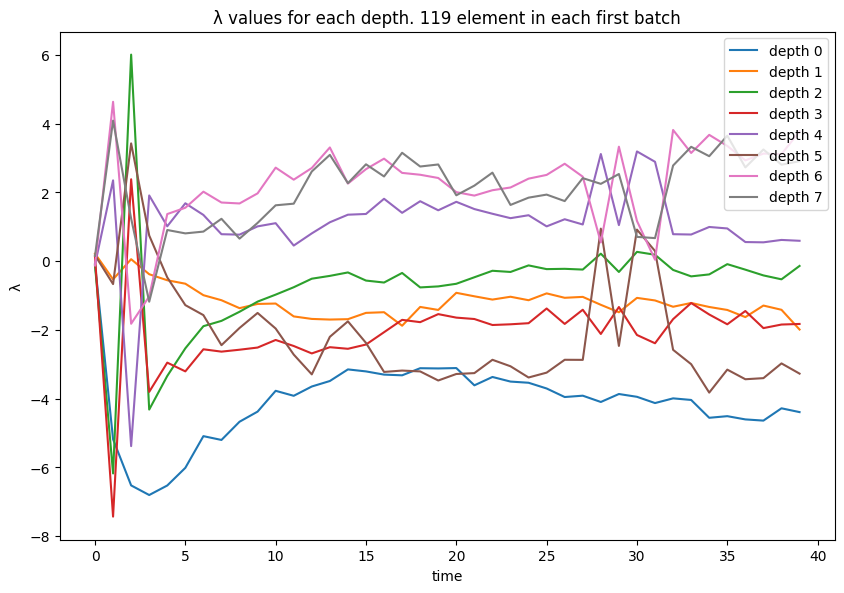

In [11]:
zz = np.array(net_FFF.fc1.get_lambdas())
depth = zz.shape[0] // 40

for i in range(10):
  element = 0 if (i == 0) else np.random.randint(0, zz.shape[-1])
  for i in range(depth):
    plt.plot(zz.reshape(40,depth,128)[:, i, element], label=f'depth {i}')
  plt.legend(loc='upper right')
  plt.title(f'λ values for each depth. {element} element in each first batch')
  plt.xlabel('time')
  plt.ylabel('λ')
  plt.show()

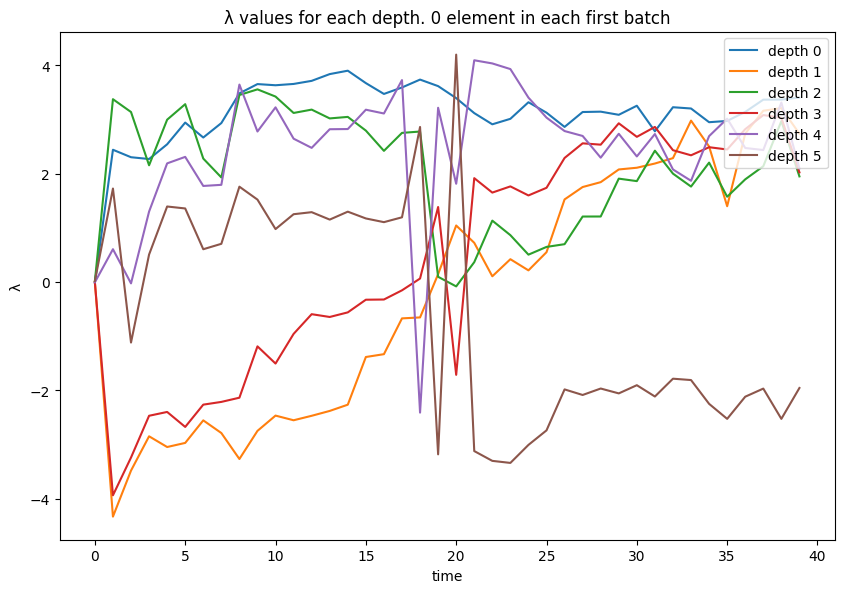

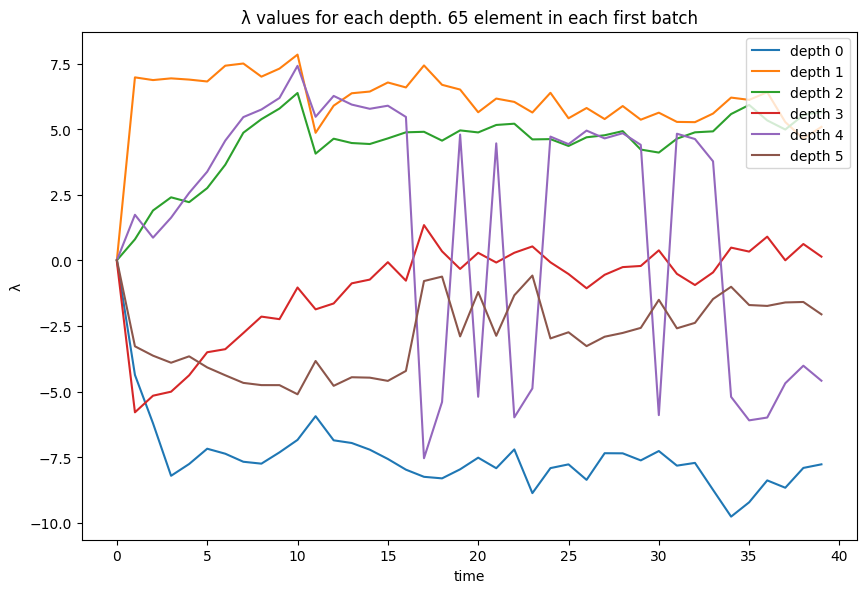

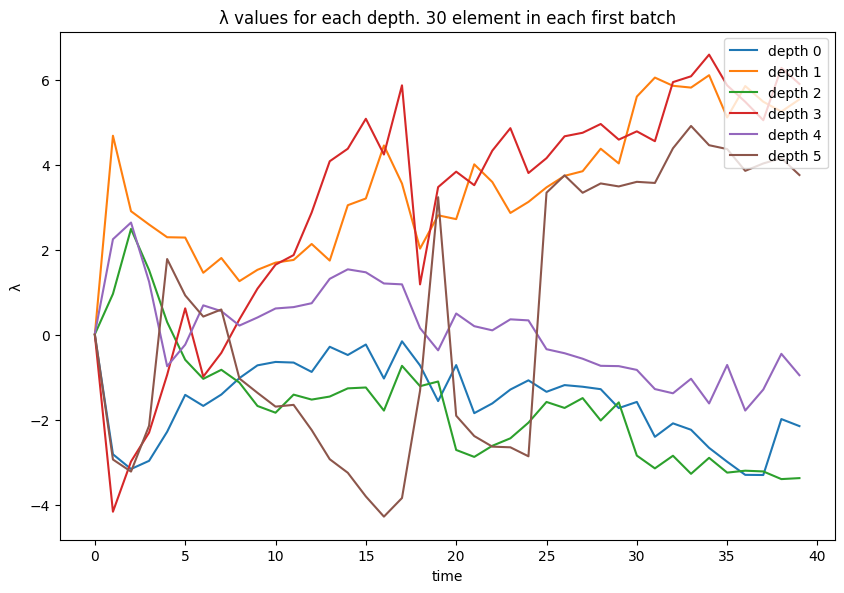

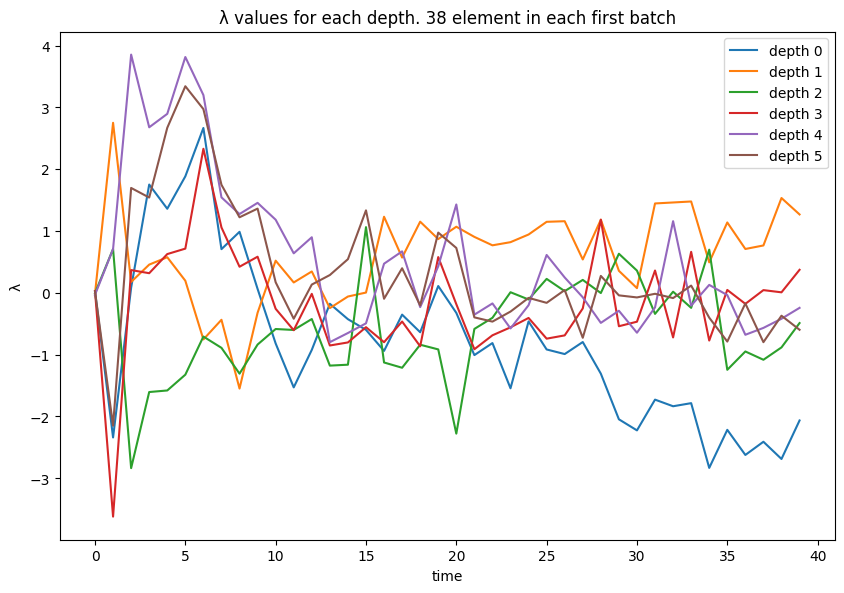

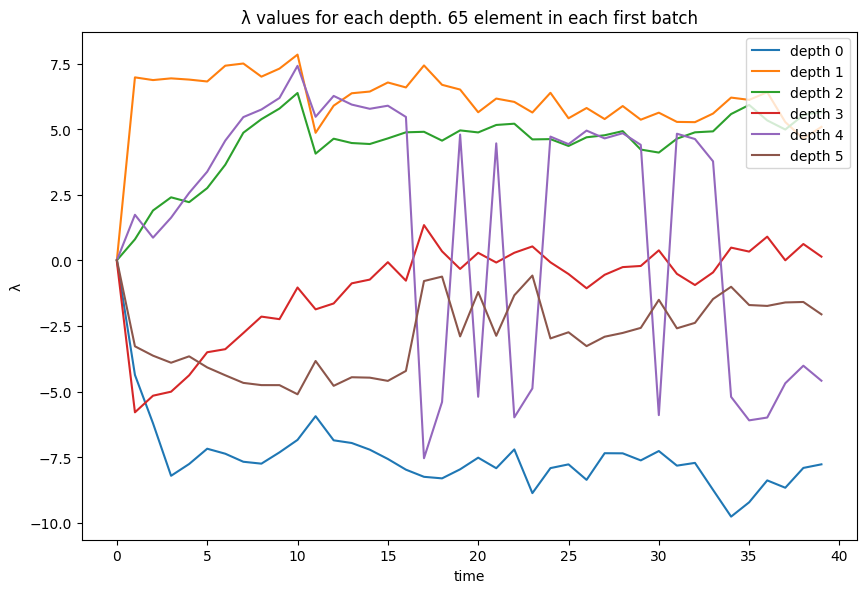

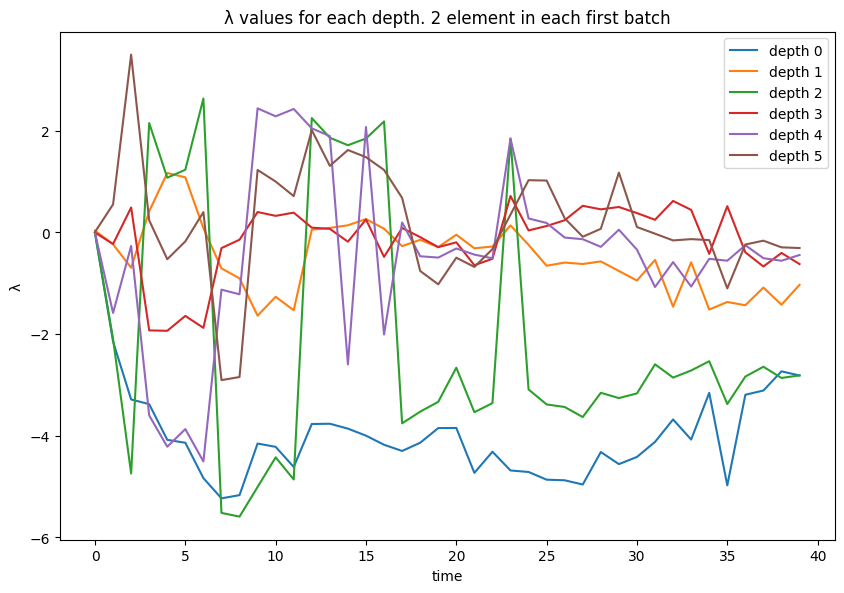

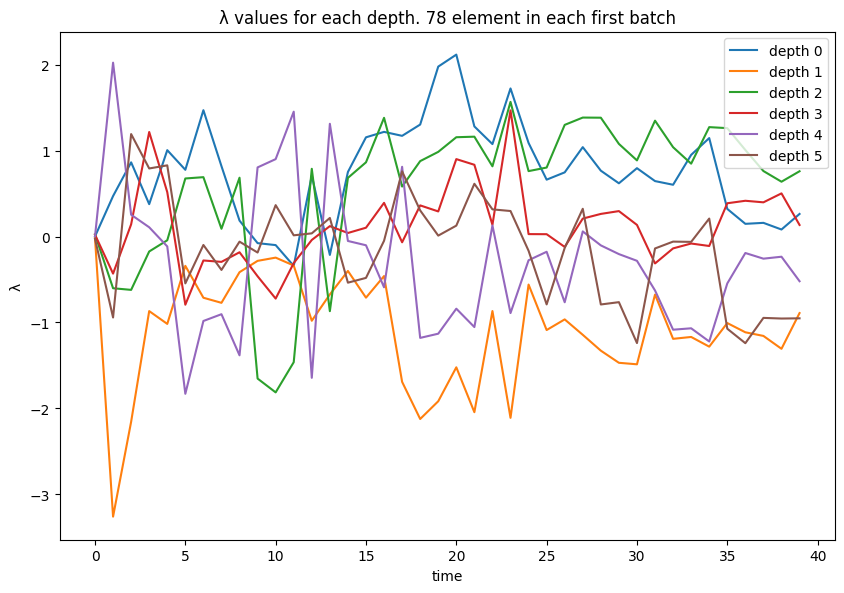

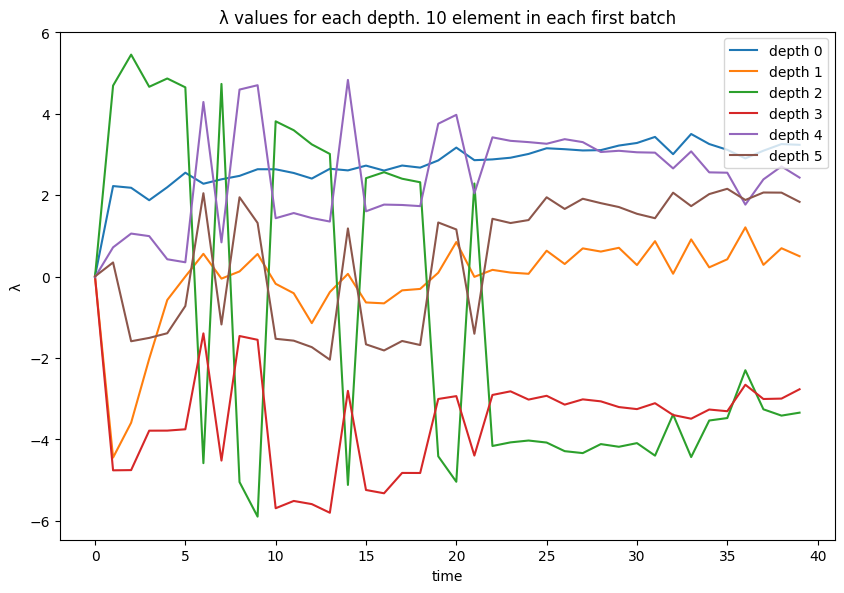

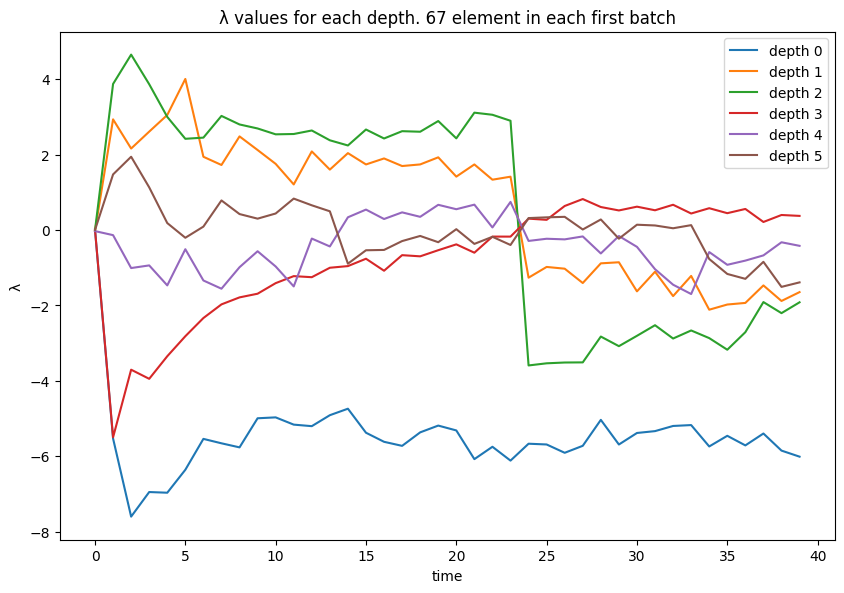

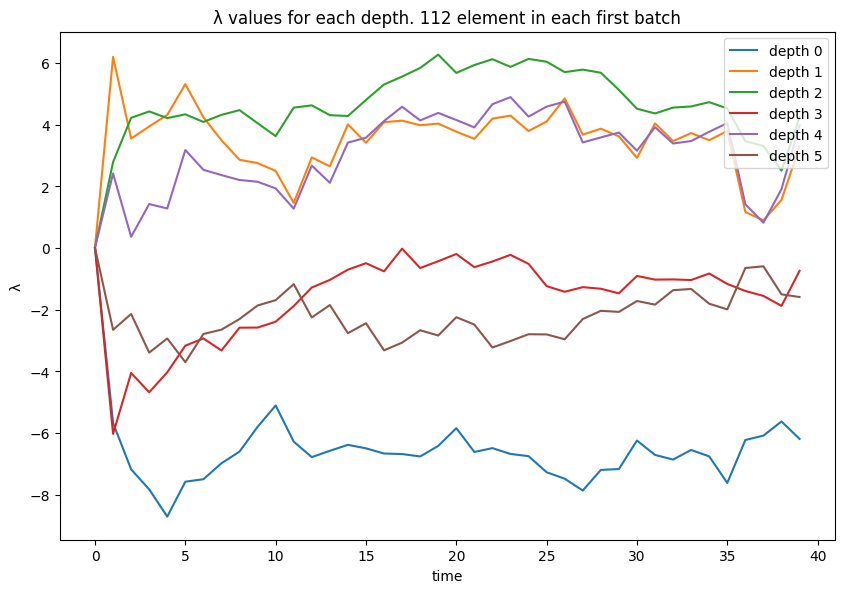

In [12]:
zz = np.array(net_FFF.fc2.get_lambdas())
depth = zz.shape[0] // 40

for i in range(10):
  element = 0 if (i == 0) else np.random.randint(0, zz.shape[-1])
  for i in range(depth):
    plt.plot(zz.reshape(40,depth,128)[:, i, element], label=f'depth {i}')
  plt.legend(loc='upper right')
  plt.title(f'λ values for each depth. {element} element in each first batch')
  plt.xlabel('time')
  plt.ylabel('λ')
  plt.show()

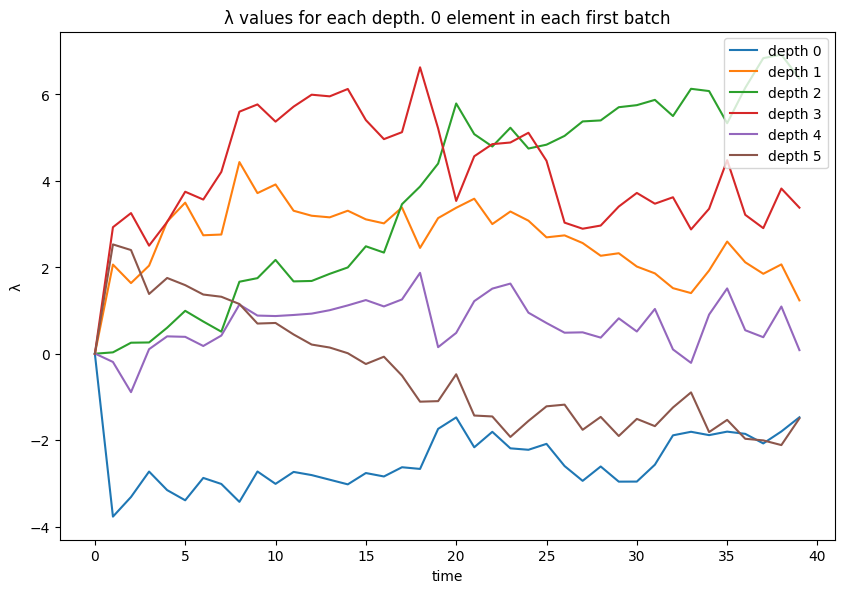

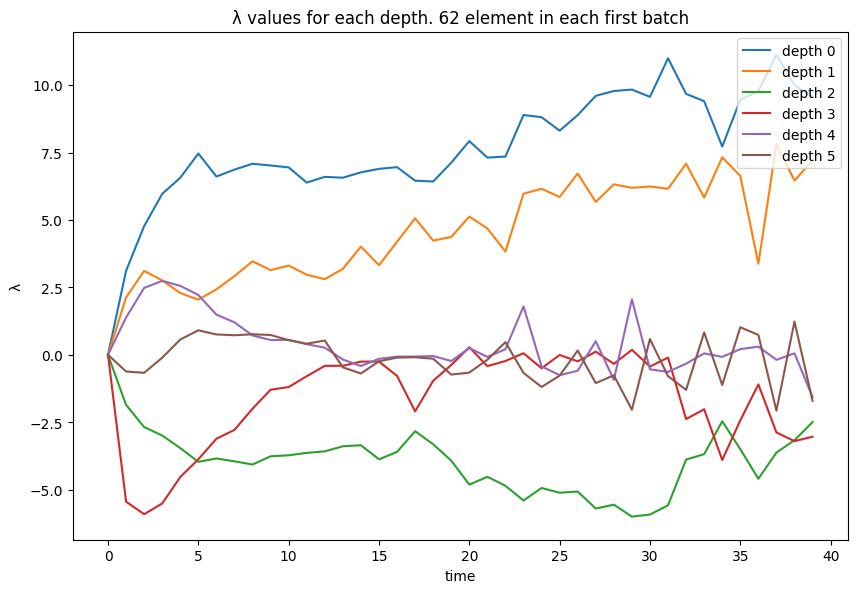

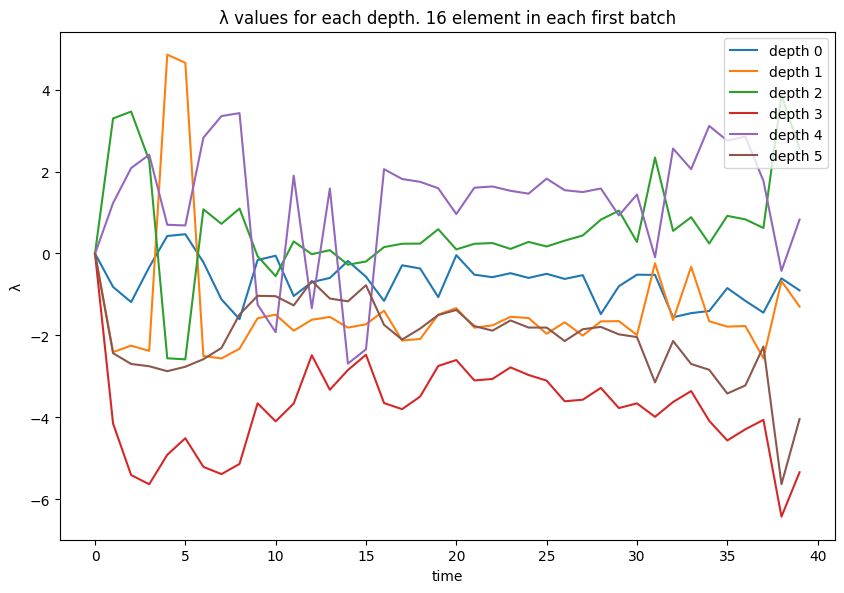

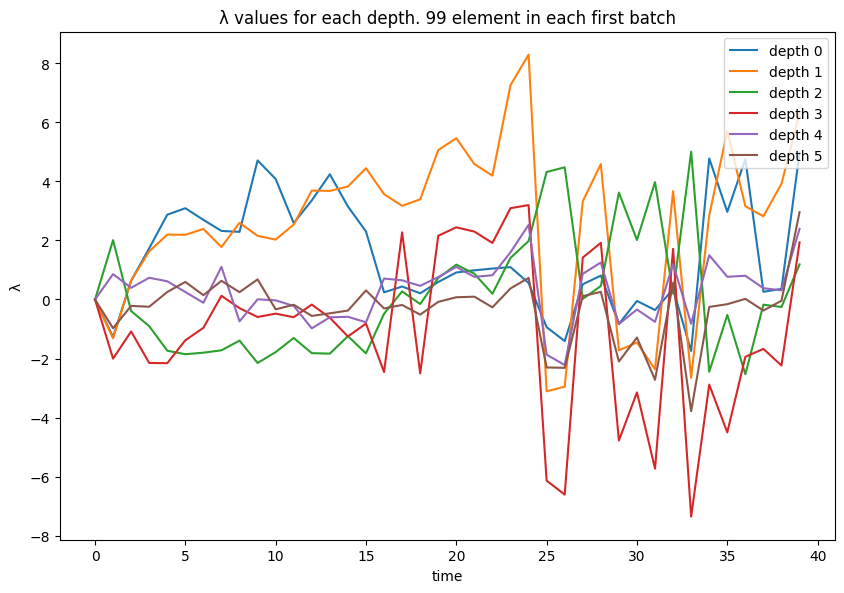

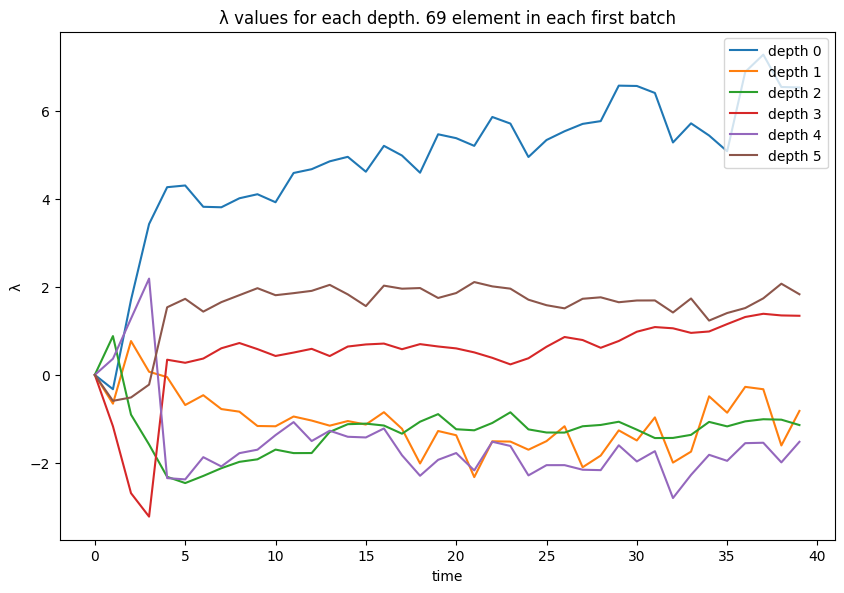

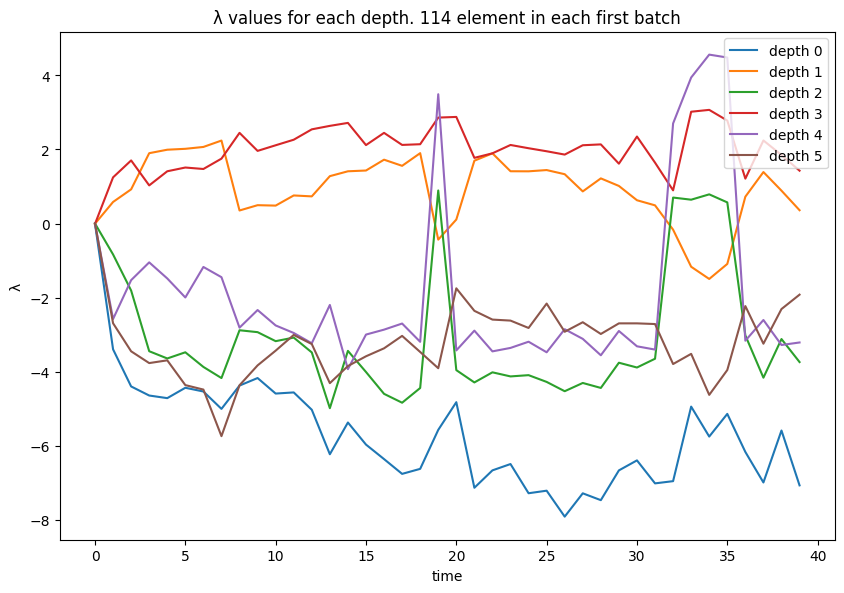

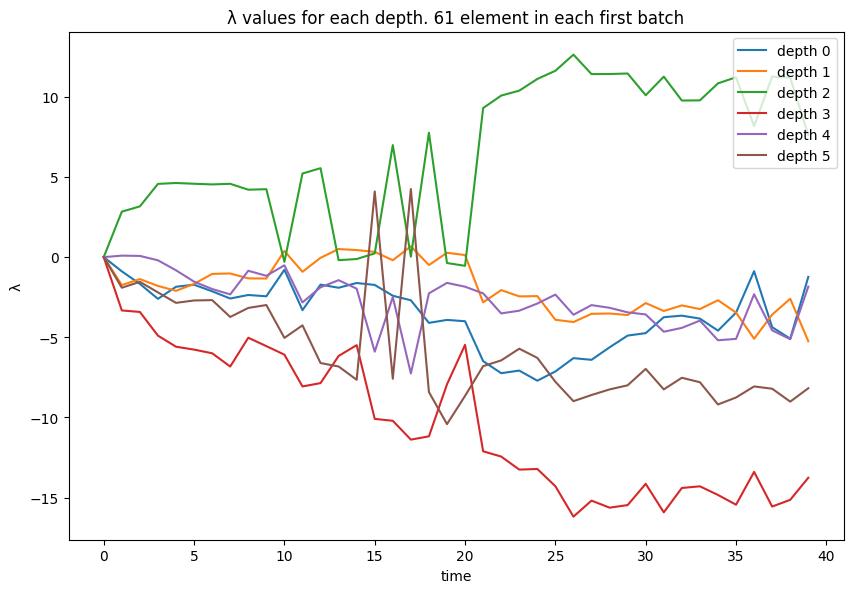

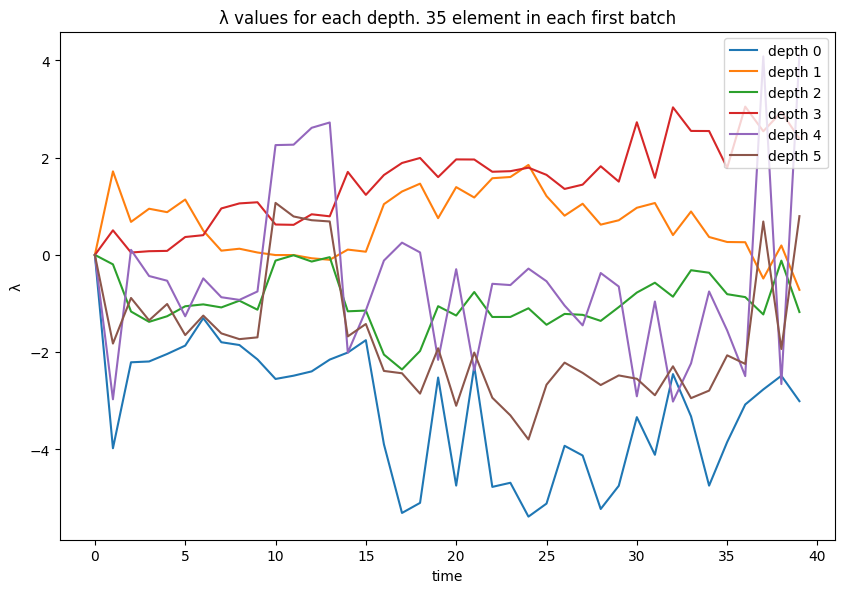

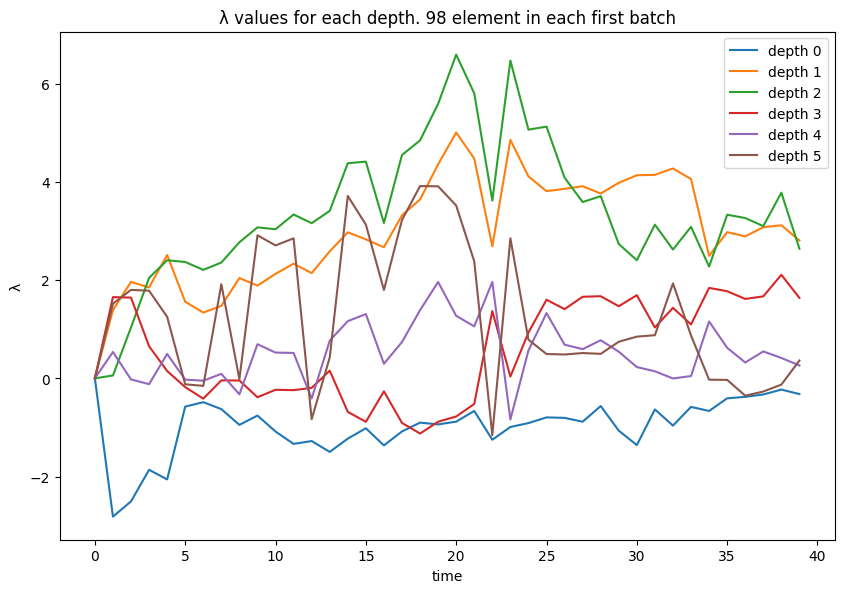

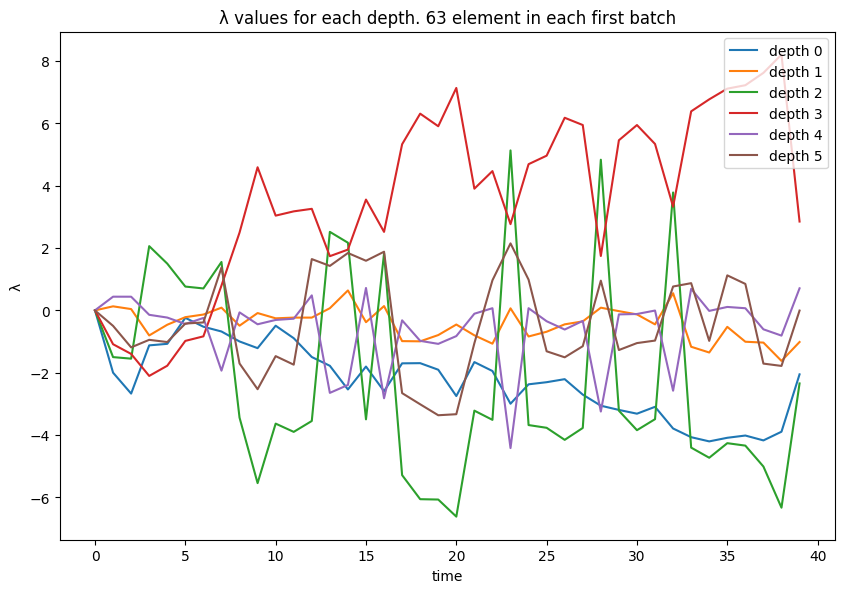

In [13]:
zz = np.array(net_FFF.fc3.get_lambdas())
depth = zz.shape[0] // 40

for i in range(10):
  element = 0 if (i == 0) else np.random.randint(0, zz.shape[-1])
  for i in range(depth):
    plt.plot(zz.reshape(40,depth,128)[:, i, element], label=f'depth {i}')
  plt.legend(loc='upper right')
  plt.title(f'λ values for each depth. {element} element in each first batch')
  plt.xlabel('time')
  plt.ylabel('λ')
  plt.show()